In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [180]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:] #  sepal width and petal length of either class Iris-Versicolor or Iris-Virginica
le = LabelEncoder()
y = le.fit_transform(y) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

In [164]:
# Reminder from Ch4
# LabelEncoder transforms lables into 0 to n-1 classes
print('classes: {}'.format(le.classes_))
print('transform [1,2]: {}'.format(le.transform([1,2])))
print('inverse transform [0,1]: {}'.format(le.inverse_transform([0,1])))

classes: [1 2]
transform [1,2]: [0 1]
inverse transform [0,1]: [1 2]


In [165]:
# majority vote ensemble
import operator

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators

class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    # classiiers is an array of each of the individual classifier/pipeline used for voting
    def __init__(self, classifiers, vote='classlabel', weights=None):
        self.classifiers = classifiers
        self.named_classifiers = { key: value for key, value in _name_estimators(classifiers) }
        self.vote = vote
        self.weights = weights # if none given, will calculate by equal weights
                                  
    def fit(self, X, y):
        # ideally, the same label encoder can be reused, but since y is not passed it during init, it cannot be done
        # note: in the example, relabelling is not actually necessary since it is already manipulated
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = [] # a better name would be fitted_classifier
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
    
    # following sklearn tradition, predict returns prediction of classlabels
    def predict(self, X):
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1) # use predict_proba method; I feel should move argmax into the method
        else:  # 'classlabel' vote, default
            maj_vote = self.predict_label(X)
        return maj_vote

    # Note: cross_val_score calls #predict_proba to evaluate accuracy
    # following sklearn tradition, predict_proba returns prediction of probabilities
    def predict_proba(self, X):
        # store each classifier's predict_proba scores in the array 'probas'
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        # the following line seems somewhat of a hack, 
        # it calculates the averages of the classifiers scores for each sample
        # and return the scores as an array, just like the original score array
        # if not using this hack, will probably need to reshape the arrays
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba
        
    def predict_label(self, X):
        #  Collect results from clf.predict calls
        predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
        maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=self.weights)), axis=1, arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote
        
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier,self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy() # hash { name_of_clf: clf_object, ... }
            for name, step in six.iteritems(self.named_classifiers): # six.iteritems = dict.get_items() for python 3
                for key, value in six.iteritems(step.get_params(deep=True)): # calls get_params method (defined by the clf) on the clf, return { param_name: val }
                    out['%s__%s' % (name, key)] = value # prepend classifier name to each of the clf params
            return out

In [166]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=11, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
clf_labels = ['Logistic Regression', "Decision Tree", "KNN"]

# note: Log Regression and KNN requires standardization, but Decision Tree does not
pipe1 = Pipeline([
    ['sc', StandardScaler()], 
    ['clf', clf1]
])
pipe3 = Pipeline([
    ['sc', StandardScaler()], 
    ['clf', clf3]
])  

print ("Individual classifiers")
print('!0-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='roc_auc'
    )
    print('ROC AUC: {} (+/- {}) [{}]'.format(scores.mean(), scores.std(), label))

Individual classifiers
!0-fold cross validation:

ROC AUC: 0.9166666666666667 (+/- 0.2006932429798716) [Logistic Regression]
ROC AUC: 0.9166666666666667 (+/- 0.15365907428821476) [Decision Tree]
ROC AUC: 0.9333333333333333 (+/- 0.10408329997330663) [KNN]


In [167]:
print("+ Ensemble Classifier")

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores =  cross_val_score(
        estimator=clf,
        X=X_train,
        y=y_train,
        cv=10,
        scoring='roc_auc'
    )
    print('ROC AUC: {} (+/- {}) [{}]'.format(scores.mean(), scores.std(), label))

+ Ensemble Classifier
ROC AUC: 0.9166666666666667 (+/- 0.2006932429798716) [Logistic Regression]
ROC AUC: 0.9166666666666667 (+/- 0.15365907428821476) [Decision Tree]
ROC AUC: 0.9333333333333333 (+/- 0.10408329997330663) [KNN]
ROC AUC: 0.9666666666666668 (+/- 0.09999999999999998) [Majority Voting]


Text(0,0.5,'True Positive Rate')

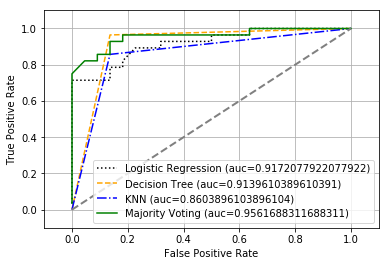

In [168]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the +ve class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1] # prob of positive class
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='{} (auc={})'.format(label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], linestyle='--', color='gray', linewidth=2) # line for random guessing
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Text(-10.5,4.5,'Petal length [standardized]')

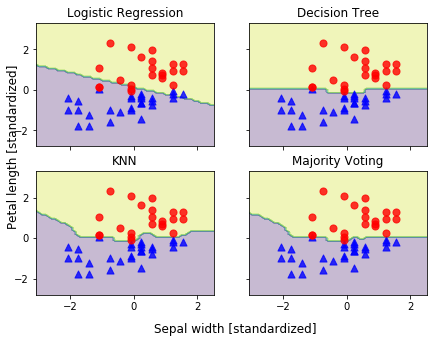

In [181]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

from itertools import product

# could use the one in ch3; the following simply plots it in the same graph
x1_min, x1_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
x2_min, x2_max = X_train_std[:, 1].min() - 1, X_train_std[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                       np.arange(x2_min, x2_max, 0.1))

f, axarr = plt.subplots(
    nrows=2, ncols=2,
    sharex='col',
    sharey='row',
    figsize=(7, 5)
)

for idx, classifier, tt in zip(product([0, 1], [0, 1]), all_clf, clf_labels):
    classifier.fit(X_train_std, y_train)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    axarr[idx[0], idx[1]].contourf(xx1, xx2, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 0, 0], X_train_std[y_train == 0, 1], alpha=0.8, c='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train == 1, 0], X_train_std[y_train == 1, 1], alpha=0.8, c='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_title(tt)
plt.text(-3.5, -4.5, s='Sepal width [standardized]', ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, s='Petal length [standardized]', ha='center', va='center', fontsize=12, rotation=90)

In [170]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=N

In [171]:
# tuning the majority vote classifier

from sklearn.grid_search import GridSearchCV
params = {
    'decisiontreeclassifier__max_depth': [1, 2],
    'pipeline-1__clf__C': [0.001, 0.1, 100.0]
}

grid = GridSearchCV(
    estimator=mv_clf,
    param_grid=params,
    cv=10,
    scoring='roc_auc'
)

grid.fit(X_train, y_train)

for params, mean_score, scores in grid.grid_scores_: # note: is sklearn v0.20, grid_scores_ becomes cv_results_
    print("%0.3f+/-%0.2f %r" % (mean_score, scores.std() / 2, params))
    
print('results show a lower regularization strength results in greater accuracy, while tree depth has no effect

SyntaxError: EOL while scanning string literal (<ipython-input-171-dc2f514c2a07>, line 21)

In [205]:
# Bagging Classifier, an example is Random Forests
# See simple explanation:
# https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/
# Essentially create multiple(500+) samples, each trained into a different classifier
# in order to approximate towards the real population
# so there will be less overfitting when compared to using a single sample
# Note: compared to Random Forests, the no of features of each classifier is not limited(by default)
# meaning classifiers may have a higher correlation to each other and reduce its efficacy compared to Random Forests

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = [
    'Class label', 
    'Alcohol',
    'Malic acid', 'Ash',
    'Alcalinity of ash',
    'Magnesium', 'Total phenols',
    'Flavanoids', 'Nonflavanoid phenols',
    'Proanthocyanins',
    'Color intensity', 'Hue',
    'OD280/OD315 of diluted wines',
    'Proline'
]
df_wine = df_wine[df_wine['Class label'] != 1] # filtering out samples with label == 1
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values # limiting components to alcohol and hue

In [201]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [202]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=None)
bag = BaggingClassifier(
    base_estimator=tree,
    n_estimators=500,
    max_samples=1.0,
    max_features=1.0,
    bootstrap=True, # whether samples are drawn with replaccement
    bootstrap_features=False, # whether features are drawn with replaccement
    n_jobs=1,
    random_state=1
)

from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (bag_train, bag_test))

Decision tree train/test accuracies 1.000/0.833
Decision tree train/test accuracies 1.000/0.896


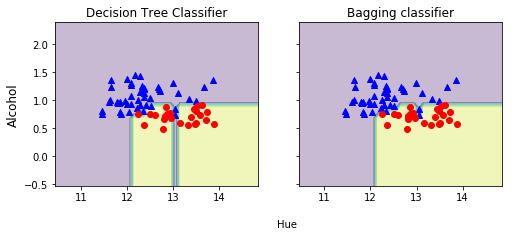

In [204]:
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                       np.arange(x2_min, x2_max, 0.1))

f, axarr = plt.subplots(
    nrows=1, ncols=2,
    sharex='col',
    sharey='row',
    figsize=(8, 3)
)

for idx, classifier, tt in zip([0, 1], [tree, bag], ['Decision Tree Classifier', 'Bagging classifier']):
    classifier.fit(X_train, y_train)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    axarr[idx].contourf(xx1, xx2, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center')
plt.show()

In [215]:
# Adaptive Boosting
# simple explanation: for each iteration/classifier, the weight of the misidenfied samples are increased 
# and the weights of the correctly identified are decreased (by a certain coeff. calculated by exp(0.5ln(err_perc)/err_perc))
# at the end, take the majority vote of all classifiers

from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=500,
    learning_rate=0.1,
    random_state=0
)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (tree_train, tree_test))

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f' % (ada_train, ada_test))

Decision tree train/test accuracies 0.845/0.854
Decision tree train/test accuracies 1.000/0.875


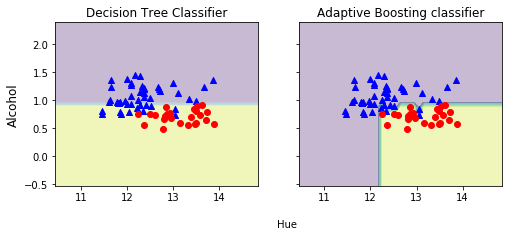

In [216]:
x1_min, x1_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
x2_min, x2_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.1),
                       np.arange(x2_min, x2_max, 0.1))

f, axarr = plt.subplots(
    nrows=1, ncols=2,
    sharex='col',
    sharey='row',
    figsize=(8, 3)
)

for idx, classifier, tt in zip([0, 1], [tree, ada], ['Decision Tree Classifier', 'Adaptive Boosting classifier']):
    classifier.fit(X_train, y_train)
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    axarr[idx].contourf(xx1, xx2, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2, s='Hue', ha='center', va='center')
plt.show()